In [1]:
from astropy.io import fits
import numpy as np
import glob
from astropy.modeling import models, fitting, functional_models
import matplotlib.pyplot as plt

In [46]:
def addstarpeak(dir, debug=False, verbose=False, mask=False, ghost=True, wl='Line'):
    """
    fits star (or ghost) and adds STARPEAK to header. needed for PyKLIP.
    :param dir: directory
    :param amp: amplitude guess
    :param fwhm: fwhm
    :param debug: will print comparison of peak pixel values to fit values if set
    :param mask: will mask NaNs with zeros for fitting if set
    :param ghost: will fit ghost in lieu of star and return ghost peak and estimate for star peak in header.
    :param wl: set if ghost is set so it knows which scale factor to pull. values are "Line" or "Cont"
    :return: list of star (or ghost) peaks
    """
    filelist = glob.glob(dir + '/*.fits')
    ##sort sequentially
    filelist.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
    n = len(filelist)
    dummy_im = fits.getdata(filelist[0])
    size = dummy_im.shape
    xcen = int((size[0] - 1) / 2)
    ycen = int((size[1] - 1) / 2)
    # guesses for fit parameters. used as starting point
    # input_parameters = [0, amp, xcen, ycen, fwhm, fwhm, 0]
    if ghost == True:
        gxcen = int(xcen + 157.5)
        gycen = int(ycen - 7)
#         if wl == "Line":
#             ghost_scale = 184.7
#         if wl == "Cont":
#             ghost_scale = 193.6
#         if wl == "False":
#             "wl keyword must be set for ghost calibration"
#             return
    diff = np.zeros(len(filelist))
    peaks = []
    fwhmlist = []
    if ghost:
        gpeaks = []
        gfwhmlist = []
    #size of image stamp
    width = 31
    stmpsz = int((width - 1) / 2)

    for i in np.arange(len(filelist)):
        im = fits.getdata(filelist[i])
        # make a copy - only invoked in case of ghost=True, but can't think of a cleverer way
        imcopy = np.copy(im)
        head = fits.getheader(filelist[i])
        #crop around star (or ghost) for fitting
        imcopy = imcopy[ycen - stmpsz-1:ycen + stmpsz, xcen - stmpsz-1:xcen + stmpsz]

        #set up fit
        y,x = np.mgrid[:width,:width]
        #Moffat PSF model
        g_init=models.Moffat2D(np.nanmax(imcopy), stmpsz, stmpsz, 6, 1)
        fit_g=fitting.LevMarLSQFitter()

        # do fit
        p=fit_g(g_init,x,y,imcopy)
        
        if ghost:
            gimcopy = np.copy(im)
            gimcopy = gimcopy[gycen - stmpsz-1:gycen + stmpsz, gxcen - stmpsz-1:gxcen + stmpsz]
            gy, gx = np.mgrid[:width,:width]
            gg_init=models.Moffat2D(np.nanmax(gimcopy), stmpsz, stmpsz, 6, 1)
            gp = fit_g(gg_init,gx,gy,gimcopy)

        # populate headers for each individual image
        if ghost == True:
            head['GSTPEAK'] = gp.amplitude.value
            head['STARPEAK'] = p.amplitude.value
            head['GSTFWHM'] = str(gp.fwhm)
            head['FWHM'] = str(p.fwhm)            
    
        else:
            head['STARPEAK'] = p.amplitude.value
            head['FWHM'] = str(p.fwhm)

        # record peak
        peaks.append(p.amplitude.value)
        # record fwhm
        fwhmlist.append(p.fwhm)
        if ghost:
            gpeaks.append(gp.amplitude.value)
            gfwhmlist.append(gp.fwhm)

        # print a warning if any peak values are unphysical
        if verbose:
            if (p.amplitude.value < 0) or (p.amplitude.value > 17000) or (np.isnan(p.amplitude.value)) == True:
                print("warning: unphysical peak value of", p.amplitude.value, 'for image', i + 1)

        # write out file with peak info in header
#         if ghost == True:
#             fits.writeto(filelist[i], im, header=head, overwrite=True)
#         else:
#             fits.writeto(filelist[i], im, header=head, overwrite=True)

        if debug == True:
            # print(filelist[i])
            # print('fit peak is:', p[0], '. max pixel is: ', np.nanmax(im[cen-10:cen+10,cen-10:cen+10]))
            imsz = im.shape[1]
            imcen = int((imsz - 1) / 2.)
            diff[i] = p.amplitude.value - np.nanmax(im[imcen - 10:imcen + 10, imcen - 10:imcen + 10])

    # write out list of peaks one directory up so KLIP doesn't try to pull it
    if ghost == True:
        fits.writeto(dir + '../' + str(wl) + 'ghostpeaks.fits', np.array(peaks), overwrite=True)
        fits.writeto(dir + '../' + str(wl) + 'fwhmlist.fits', np.array(fwhmlist), overwrite=True)
    else:
        fits.writeto(dir + '../' + str(wl) + 'starpeaks.fits', np.array(peaks), overwrite=True)
        fits.writeto(dir + '../' + str(wl) + 'fwhmlist.fits', np.array(fwhmlist), overwrite=True)

    if debug == True:
        print('standard deviation of difference between fit peak and max pixel is: ', np.std(diff))
        print('max difference is:', np.max(abs(diff)))
        print('median difference is:', np.median(diff))
    return n, np.array(peaks), np.array(fwhmlist), np.array(gpeaks), np.array(gfwhmlist)

In [53]:
n, peaks, fwhmlist, gpeaks, gfwhmlist = addstarpeak('../forwardModel/data/8Apr14/Ha_90pct/', debug=True)

standard deviation of difference between fit peak and max pixel is:  426.67201580164766
max difference is: 2200.868822216864
median difference is: 835.4235235458209


In [54]:
x = np.linspace(1,n+1, num=n)

# some calcs
peakmed = np.nanmedian(peaks)
peakstd = np.std(peaks)
gpeakmed = np.nanmedian(gpeaks)
gpeakstd = np.std(gpeaks)

fwhmmed = np.nanmedian(fwhmlist)
fwhmstd = np.std(fwhmlist)
gfwhmmed = np.nanmedian(gfwhmlist)
fwhmstd = np.std(gfwhmlist)

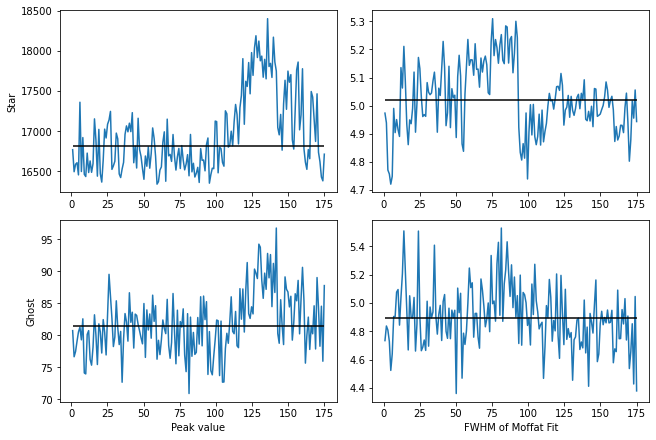

In [60]:
# plotting to show values
fig = plt.figure(constrained_layout=True, figsize=(9,6))
ax_dict = fig.subplot_mosaic(
    [
        ["starpeak", "starfwhm"],
        ["ghostpeak", "ghostfwhm"],
    ],
)

ax_dict["starpeak"].set_ylabel("Star")
ax_dict["ghostpeak"].set_ylabel("Ghost")
ax_dict["ghostpeak"].set_xlabel("Peak value")
ax_dict["ghostfwhm"].set_xlabel("FWHM of Moffat Fit")

ax_dict["starpeak"].plot(x, peaks)
ax_dict["starpeak"].hlines(peakmed, x.min(), x.max(), 'k', zorder=3)
ax_dict["ghostpeak"].plot(x, gpeaks)
ax_dict["ghostpeak"].hlines(gpeakmed, x.min(), x.max(), 'k', zorder=3)

ax_dict["starfwhm"].plot(x, fwhmlist)
ax_dict["starfwhm"].hlines(fwhmmed, x.min(), x.max(), 'k', zorder=3)
ax_dict["ghostfwhm"].plot(x, gfwhmlist)
ax_dict["ghostfwhm"].hlines(gfwhmmed, x.min(), x.max(), 'k', zorder=3)

# plt.yscale('log')
plt.savefig('ghostInvestigation_8Apr14_Ha_90pct.png', dpi=300)

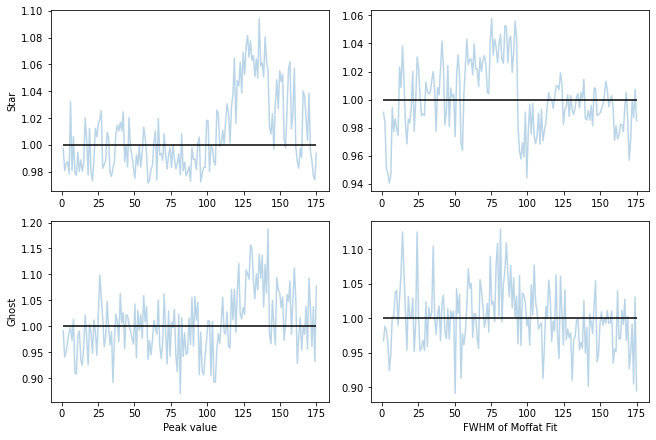

In [59]:
# plotting relative to median
fig = plt.figure(constrained_layout=True, figsize=(9,6))
ax_dict = fig.subplot_mosaic(
    [
        ["starpeak", "starfwhm"],
        ["ghostpeak", "ghostfwhm"],
    ],
)

ax_dict["starpeak"].set_ylabel("Star")
ax_dict["ghostpeak"].set_ylabel("Ghost")
ax_dict["ghostpeak"].set_xlabel("Peak value")
ax_dict["ghostfwhm"].set_xlabel("FWHM of Moffat Fit")

ax_dict["starpeak"].plot(x, peaks/peakmed, alpha=0.3)
ax_dict["starpeak"].hlines(1, x.min(), x.max(), 'k', zorder=3)
ax_dict["ghostpeak"].plot(x, gpeaks/gpeakmed, alpha=0.3)
ax_dict["ghostpeak"].hlines(1, x.min(), x.max(), 'k', zorder=3)

ax_dict["starfwhm"].plot(x, fwhmlist/fwhmmed, alpha=0.3)
ax_dict["starfwhm"].hlines(1, x.min(), x.max(), 'k', zorder=3)
ax_dict["ghostfwhm"].plot(x, gfwhmlist/gfwhmmed, alpha=0.3)
ax_dict["ghostfwhm"].hlines(1, x.min(), x.max(), 'k', zorder=3)